**使用Python爬取豆瓣电影Top250**

计算社会科学善于借助新的工具来获得并分析互联网上的数字痕迹，研究者可以从文本、图像以及音视频数据中挖掘潜藏的故事，回答重要的现实与理论问题。

那么如何获得数字痕迹呢？最好的方法是与数据生产方直接合作，获得他们的服务器数据，但很多时候这并不现实（出于大家了解的原因）。因此，研究者有时不得不借助网络爬虫来获取用户的数据痕迹。我们今天就会给大家进行一个简单的爬虫范例，主要目的是展示网络爬虫的基本思路以及实现方式。我们将以豆瓣电影的Top250排行榜为例，爬取排行榜中每部电影的所有基本信息，并将结果写入txt文件。

需要注意，网络爬虫具有道德风险，爬取数据严禁用作商业目的，否则具有法律风险；另外，应严格遵守学术伦理对数据进行严格保密，在适当的时候进行匿名化处理。

**一、网络爬虫由什么组成呢？**

相信大家对什么是爬虫早已有所了解，那么我们如何进行爬虫呢？仔细想想我们借助浏览器收集数据的过程，我们可以大致把数据收集分为几步：

**1. 打开目标网页**

*我们首先要找到我们的目标网页，例如B站、知乎或者豆瓣，并能正常地浏览具体的网络页面。*

这在网络爬虫中对应于发出“request”并正常地获得“response”的步骤，此时我们模拟浏览器的访问行为向目标网站发出“request”，如果目标网站认可我们的访问，它就会给我们返回正常的网络页面，也就是“response”。

**2. 获得页面上特定的信息**

*我们接下来浏览网页，并把我们需要的信息记住或复制粘贴出来，我们需要的信息通常在网页上的某些特定位置。*

这在网络爬虫中对应“parse”,也就是对网页内容进行解析。此时我们必须对目标页面的结构比较熟悉，并清楚地知道我们需要的信息在哪个固定/有规律的位置，我们在这一步需要对response的形式进行分析，或者通过审查元素的方式找到我们所需信息的标志，这些信息以页面为单位整合到一起。

**3. 把这些信息记录下来并整理在一起**

*记录好的信息被我们放到txt、excel或者database中有规律地收集起来，用于后续的分析。*

这在网络爬虫中对应“dump”,也就是对“parse”的结果（一些系列单值、文本甚至图片等等）进行整合以及保存。我们通常先准备一个容器暂时存储单页内的所有解析结果，再一起“dump”到文件里。在大型爬虫中，写入与爬取通常同时进行，这使得即使程序崩溃、网页拒绝访问时我们也能得到已经完成爬取的部分。

**4. 打开下一个目标网页**

*我们不会只看一个页面。以某个页面为起点，我们会顺序浏览大量页面*

如果只收集一个页面还要爬虫干什么呢？我们通常要爬取的是数万个甚至数百万个类似结构的页面，为此，我们通常需要对网站的层级结构以及列表结构有所了解，比如，“我们需要爬哪个分区，这个分区由哪些子分区”、“那些页面都在搜索得到的列表中吗？哪种排列顺序能获得最全的页面目录？”。也就是说，我们的爬虫有的时候有好几层，他们可能是共同进行的，但要保证“查全率”。

我们已经基本了解了网络爬虫的基本结构，现在让我们来具体看看豆瓣的网站特征，以及我们具体需要的信息是哪些？在对此有所了解后，我们就要据此设计我们的网络爬虫了。

**二、具体的代码**

**1.把jupyter的结果输出更改为“完整的输出”**

我们首先对jupyter的显示风格进行一些调整。jupyter的结果显示有时很迷，比如丢失某些输出，或者整合某些输出。我们这里的调整是让jupyter不管中间运行了什么步骤，把相应的日志全部显示出来。这样的好处是我们爬虫每次爬到新的东西都会有新的滚动内容打印出来，我们可以更好地看到爬虫的进度。

In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" 

**2.导入需要的库以及模块**

用过stata的同学都知道有些额外的命令需要我们进行安装，Python的逻辑则是我们对于需要使用的库要先进行安装，并在代码中对这些库进行导入。换句话说，无论需要什么功能要先安，之后在代码中使用时再导入。常见的导入就是两种格式“from XXX import XXX”以及直接“import XXX(.XXX)”。对于实际导入的模块，我们可以用as起别名，例如把pandas简称为pd。

In [9]:
from bs4 import BeautifulSoup as bs
import urllib
from urllib import request   
import pandas as pd
import json
import time

**3.核心的爬虫“装置”**

我在这里实际上设计了一个“装置”，这个装置可以（1）发出初始访问请求、（2）根据初始访问请求获得所有需要的访问的二级页面。（3）获取二级页面的响应、（4）对响应进行解析，并将（5）解析的结果整合起来抛出到文件中存储起来。最后，我们一旦点了这个装置的开关，他就会自动运行开始爬取。也就是说，我们相当于设计一个机器，这个机器的任务是**自动获取网站数据**，我们把这个任务分拆成几个相互联系的**小任务**再**拼装**起来。（实际上，这样一个装置在编程中称为“类”，我们可以理解为一个可以应用、交互以及使用的机器。）

In [10]:
# 我们首先定义了一个“类”，也就是class，他的名字叫DoubanSpider，豆瓣爬虫，很好理解吧！
# 定义的格式是  class XXXXXX(object):
# 我们接下来逐步实现这个“爬虫装置”的各个功能：

class DoubanSpider(object):
    
      # 我们再来看看豆瓣电影Top250的网页结构：https://movie.douban.com/top250 
      # 这里我们首先定义这个类的开关（初始函数）。当我们使用这个类时，他是第一段运行的代码
      def __init__(self):
           # 我们首先设置请求的基本参数，这在我们的整块代码中要多次用到
           # self=DoubanSpider，因而self.XXX意味着在这个类内进行设置)
            
           # 在类内设定初始url 
          self.url = "https://movie.douban.com/top250"
           # 在类内设定header，注意如果没有cookie很可能无法爬取，大家可以登录后获取自己的cookie
          self.header = {
              # 通过UA的设置把爬虫伪装成浏览器。（有些网站会做更严格的检验）
               'User-Agent':'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.71 Safari/537.36',
              # 表示用户登录状态的一系列值称为cookie，把爬虫伪装成实际用户登录
               'Cookie':'bid=P1Zy_wKBqnE; douban-fav-remind=1; __gads=ID=ceedbbbde96b04de-2231fe9a1cc700ac:T=1617946000:RT=1617946000:S=ALNI_MZxZdyPbCMQpJgH5eIIT8iXFxh70g; gr_user_id=d92a50cf-93d5-4524-ad11-46742a9a1993; viewed="6875232_3587689_6062279_1045083_6391212_5355428_25939476_26838822_26984638_5396636"; push_doumail_num=0; push_noty_num=0; __utmc=30149280; __utmc=223695111; ap_v=0,6.0; __utmv=30149280.17841; ll="108304"; _vwo_uuid_v2=D58ED292966010EF556604CC8E5A4D6C5|fcf24a724bf73442ad40d3925a39778f; _pk_ref.100001.4cf6=["","",1637658491,"http://localhost:8888/"]; _pk_ses.100001.4cf6=*; __utma=30149280.1307059282.1617946021.1637655114.1637658491.14; __utmz=30149280.1637658491.14.14.utmcsr=localhost:8888|utmccn=(referral)|utmcmd=referral|utmcct=/; __utma=223695111.2063644463.1628173107.1637655114.1637658491.3; __utmb=223695111.0.10.1637658491; __utmz=223695111.1637658491.3.3.utmcsr=localhost:8888|utmccn=(referral)|utmcmd=referral|utmcct=/; __utmt=1; dbcl2="178411550:S7MgPy3OXjg"; ck=bneY; __utmb=30149280.25.10.1637658491; _pk_id.100001.4cf6=4d47b4b05186fce1.1628173106.3.1637659586.1637656148.'
                         }
           #  在类内设定待会儿爬虫结果储存到哪个文件里 
          self.file_name = open("DoubanTop250.txt", "w", encoding="utf-8")
           #  在这一步，我们真正运行了一个函数，就是我们在下面定义的run()。爬虫正式开始。
          self.run()
            
      # 我们首先制作一个基本模块，这个模块的功能是模拟浏览器发出访问请求，并接受网站的响应，生成网页。      
      def loadPage(self,url):
          # 对Request给定访问的url以及header，以生成一个完整的访问请求
          request = urllib.request.Request(url,headers= self.header)
          # 发出访问请求，并获得网站对这个请求的响应。（对应于网页已经加载出来）
          response = urllib.request.urlopen(request)
          # 发出请求后，我们让程序小睡一会儿，来控制爬取的速度。过快的爬取不太道德，也容易被网站识别并禁止。
          time.sleep(0.3)
          # 把response的结果进行读取并储存
          html = response.read()
          # 把储存好的网页返回出来，供其他模块使用
          return html
      
      #  这是我们程序最核心的逻辑模块，代表了整个爬虫的总体思路。
      #  初始函数在完成基本参数设定后，就会调用run()开始爬取
      #  run()负责安排几个模块间的运行次序，组织整个爬虫的进行。
      def run(self):
          # run函数中可以指定我们希望爬取的豆瓣电影Top250中的页码范围
          start_page = 1
          end_page = 2
            
          # 在制定了爬取的页码范围后，我们根据网址的规律生成了这些页码对应的一级url
          for page in range(start_page, end_page + 1):
              print("正在处理第" + str(page) + "页")
              pn = (page-1)*25
              # 通过在初始网址上增加些内容，我们就获得了特定页码的url
              full_url = self.url + "?start=" + str(pn)
              # 打出来看看这些一级网址全了吗？
              print(full_url)
              # 获取了一级网址后，我们进一步对这些一级网址中每个单独电影的url进行获取
              # getPostions是我们设计的另一个模块，用于获取一级url的电影列表中每个电影页的url
              link_list = self.getPositions(full_url)
              # 获得了每个电影页的url后，我们在对每个url进行访问，并解析这些url中的信息，并储存到指定好的文件中。
              # getPositionInfo也是我们设计的一个解析模块，在每个电影页中解析、抛出并储存我们需要的信息。
              for link in link_list:
              # 我们对每个电影列表中的所有电影页都进行解析
                  self.getPositionInfo(link)
                
          # 在刚刚的代码中，每页、每页中的电影列表以及每个电影列表中的每个电影页都得到了解析、抛出以及记录
          # 因而，我们已经完成了爬取，关闭我们的储存文件。
          self.file_name.close()
        
      # 这个模块的功能是获取每页电影列表中所有电影页的url，用于后续getPositionInfo的解析、抛出以及储存。
      # 因而我们要首先借助之前已经设计好的loadPage来获取电影列表页面，并从中解析出每个电影页的url。
      def getPositions(self,url):
          # 在run函数中，每页电影列表的url传递进来了，我们使用之前设计好的loadPage进行加载
          html = self.loadPage(url)
          # 设定为中文编码
          html = html.decode("utf-8")
          # 接下来，我们需要对页面进行解析，有很多方法可以实现，这里我们使用容易上手的BeautifulSoup
          # 我们实际上要做的是对html中的信息进行检索，html中的信息是树形的，我们可以通过一定方法来检索
          # 先把加载的页面转化为BeautifulSoup的格式，这样我们就能使用BS的工具对其进行解析加工
          soup = bs(html,"html.parser") # 我们把html转化为bs对象，并指定了html.parser的解析方式
          # 先做个空的列表作为容器
          link_list = []
          # 之后把在电影列表页中把所有具有class_='pic'特征的内容挑出来
          for link in soup.find_all(class_='pic'):
              # 再访问其中a标签下的href属性值，他就是我们想要的电影页的url。（见图 1）
              text = link.a['href']
              # 打印url以便于对爬虫进程的监测
              print(text)
              # 把每个电影页的url逐个存进刚刚做的列表中
              link_list.append(text)
          # 把每页电影列表中电影页的url传递出去，等待getPositionInfo对电影页的信息进行解析、抛出以及储存。
          return link_list

      def getPositionInfo(self,url):
          # 每个电影页的url传递进来了，还是用设计好的loadPage进行加载
          html = self.loadPage(url)
          # 设定为中文编码
          html = html.decode("utf-8")
          # 把html转化为bs对象，指定html.parser的解析方式
          soup = bs(html, "html.parser")
          # 做个空的字典作为容器，以暂时储存单个电影页的解析结果
          item = {}
          # try的方式可以防止解析失败导致程序直接失败的情况，except则规定了失败时执行的操作，在我们这里直接pass
          try:
              # 对文本型单值的提取在找到对应项后用.string获取
              # 解析电影名，并打印（见图 2）
              name = soup.find(property="v:itemreviewed").string
              print("\033[31m{}\033[0m".format(name))
              # 解析电影年份，并打印（见图 3）
              year = soup.find(class_='year').string
              print(year)
              # 解析电影导演，并打印（见图 4）
              director = soup.find(rel="v:directedBy").string
              print(director)
              # 解析电影演员们，并打印（见图 5）
              # 电影演员有多个，在网页呈现并列结构，我们只需要用find_all()找全，再合并即可。
              actorslist = soup.find_all(rel="v:starring")
              actor = ''
              for actors in actorslist:
                  actor += (actors.string + '、')
              print(actor)
              # 解析电影类型，并打印（见图 6）
              # 电影类型有多个，在网页呈现并列结构，我们还是用find_all()找全，再合并即可。
              genrelist = soup.find_all(property="v:genre")
              genre = ''
              for genres in genrelist:
                  genre += (genres.string + '、')
              print(genre)
              # 解析电影放映时间，并打印（见图 7）
              # 电影放映时间是一个标签的值，找到对应项后，在后面加['标签名']可以直接获取
              ReleaseDate = soup.find(property="v:initialReleaseDate")['content']
              print(ReleaseDate)
              # 解析电影时长，并打印（见图 8）
              # 电影时长是一个标签的值，找到对应项后，在后面加['标签名']可以直接获取
              runtime = soup.find(property="v:runtime")['content']
              print(runtime)
              # 解析电影评分，并打印（见图 9）
              # 对文本型单值的提取在找到对应项后用.string获取
              score = soup.find(class_="ll rating_num",property="v:average").string
              print(score)
              # 解析电影简介，并打印（见图 10）
              # 对区域内有分块的文本可以在找到对应项后用。get_text()一并提取，但要进行清洗。
              summary = soup.find(property="v:summary").get_text()
              summary = summary.replace('\n','') # 去除多余换行
              summary = summary.replace('　','') # 去除多余长空格
              summary = summary.replace(' ','')  # 去除多余空格
              print(summary)
              # 将解析结果一一对应存入之前设定好的字典中。
              item['name'] = name
              item['year'] = year
              item['director'] = director
              item['actor'] = actor
              item['genre'] = genre
              item['ReleaseDate'] = ReleaseDate
              item['runtime'] = runtime
              item['score'] = score
              item['summary'] = summary
          except:
              pass
          # if item意味着判定item是否为空，如果不为空，则运行接下来的代码
          if item:
              # 如果item中有东西，就把item以json的格式抛出
              line = json.dumps(item, ensure_ascii=False) + "\n"
              # 把json格式的item直接写进之前设定的储存文件中，至此单个电影页的信息爬取完成。
              self.file_name.write(line)            

**图1 在电影列表中获取电影页url**

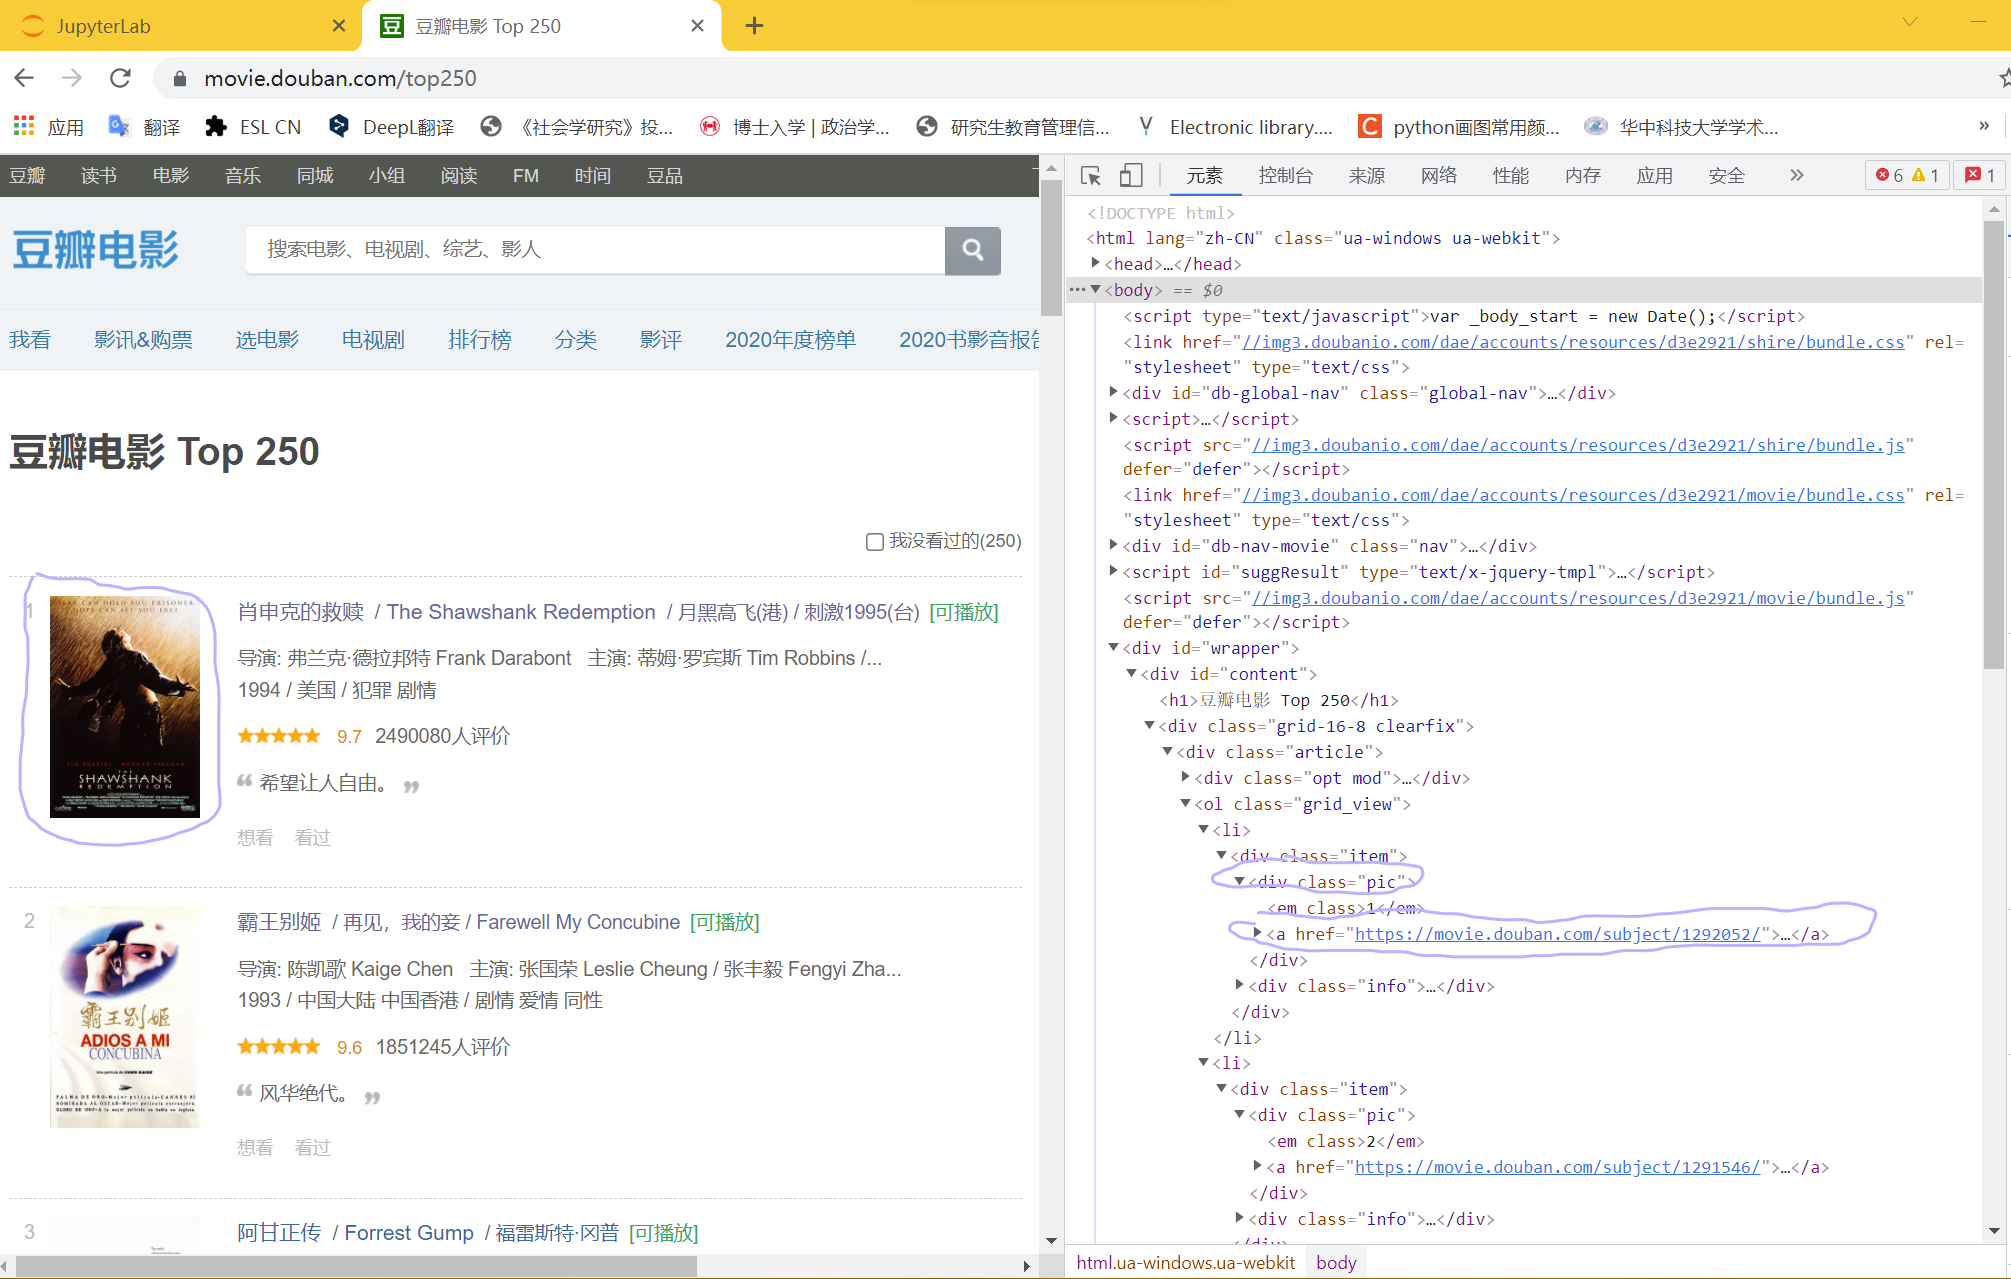

**图2 在电影页解析电影名**

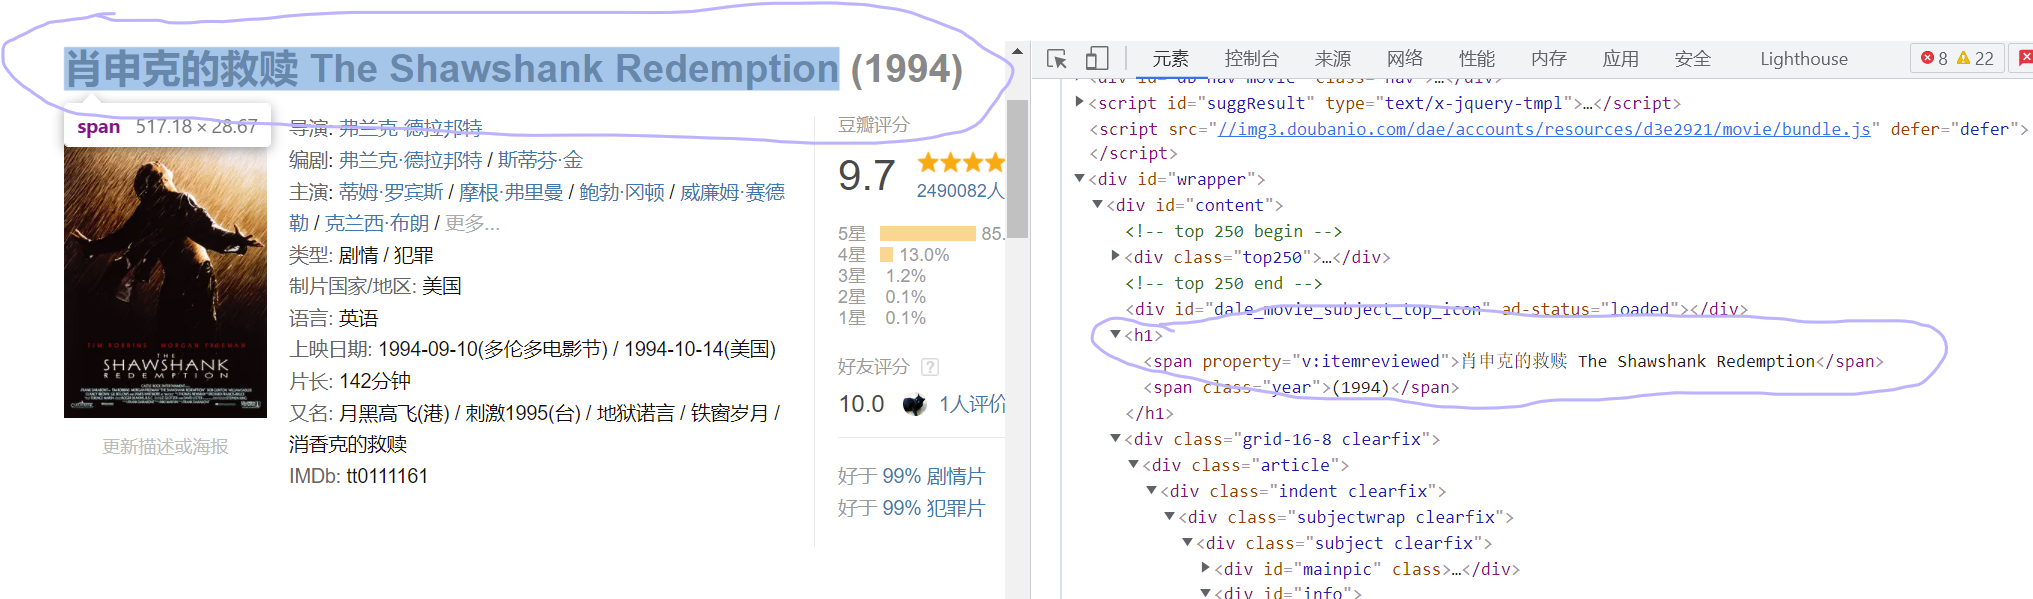

**图3 在电影页解析电影年份**

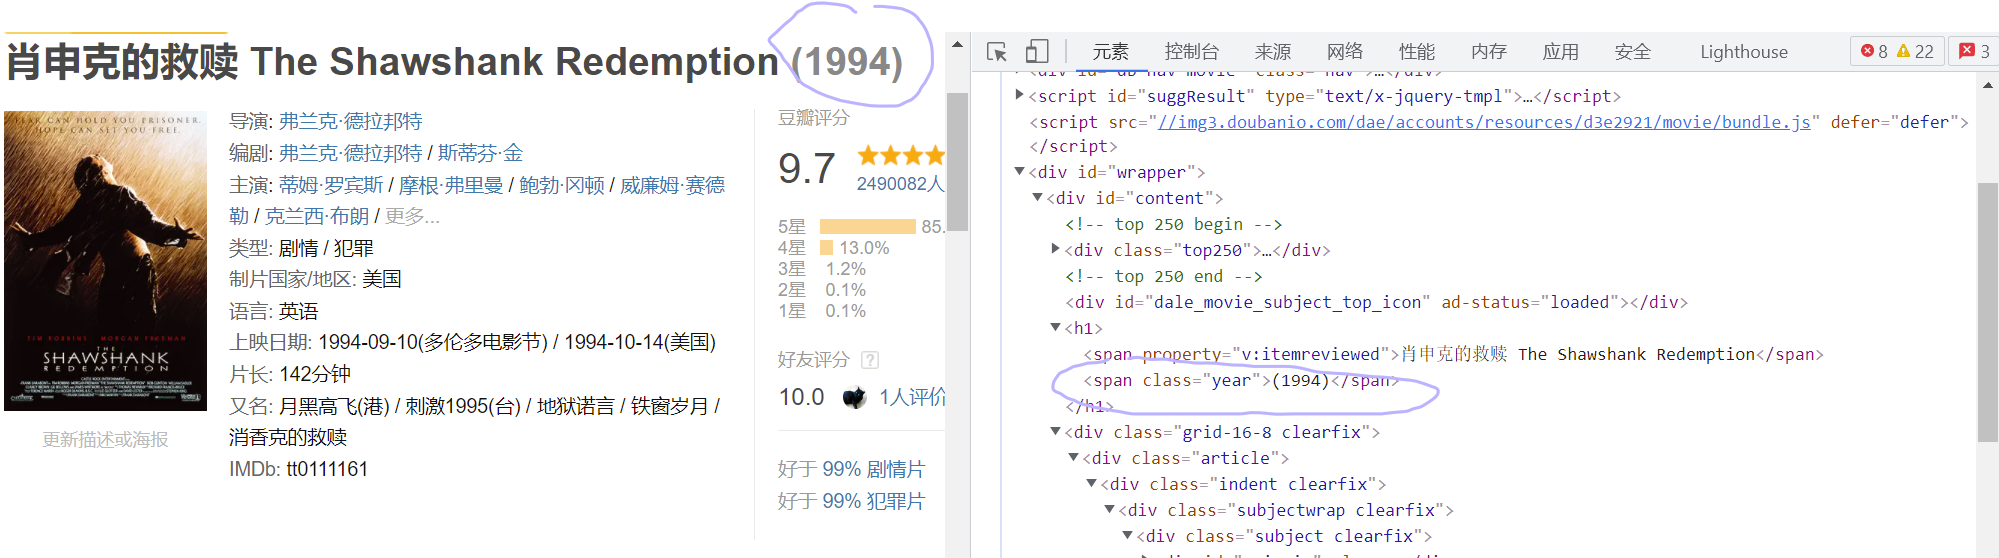

**图4 在电影页解析电影导演**

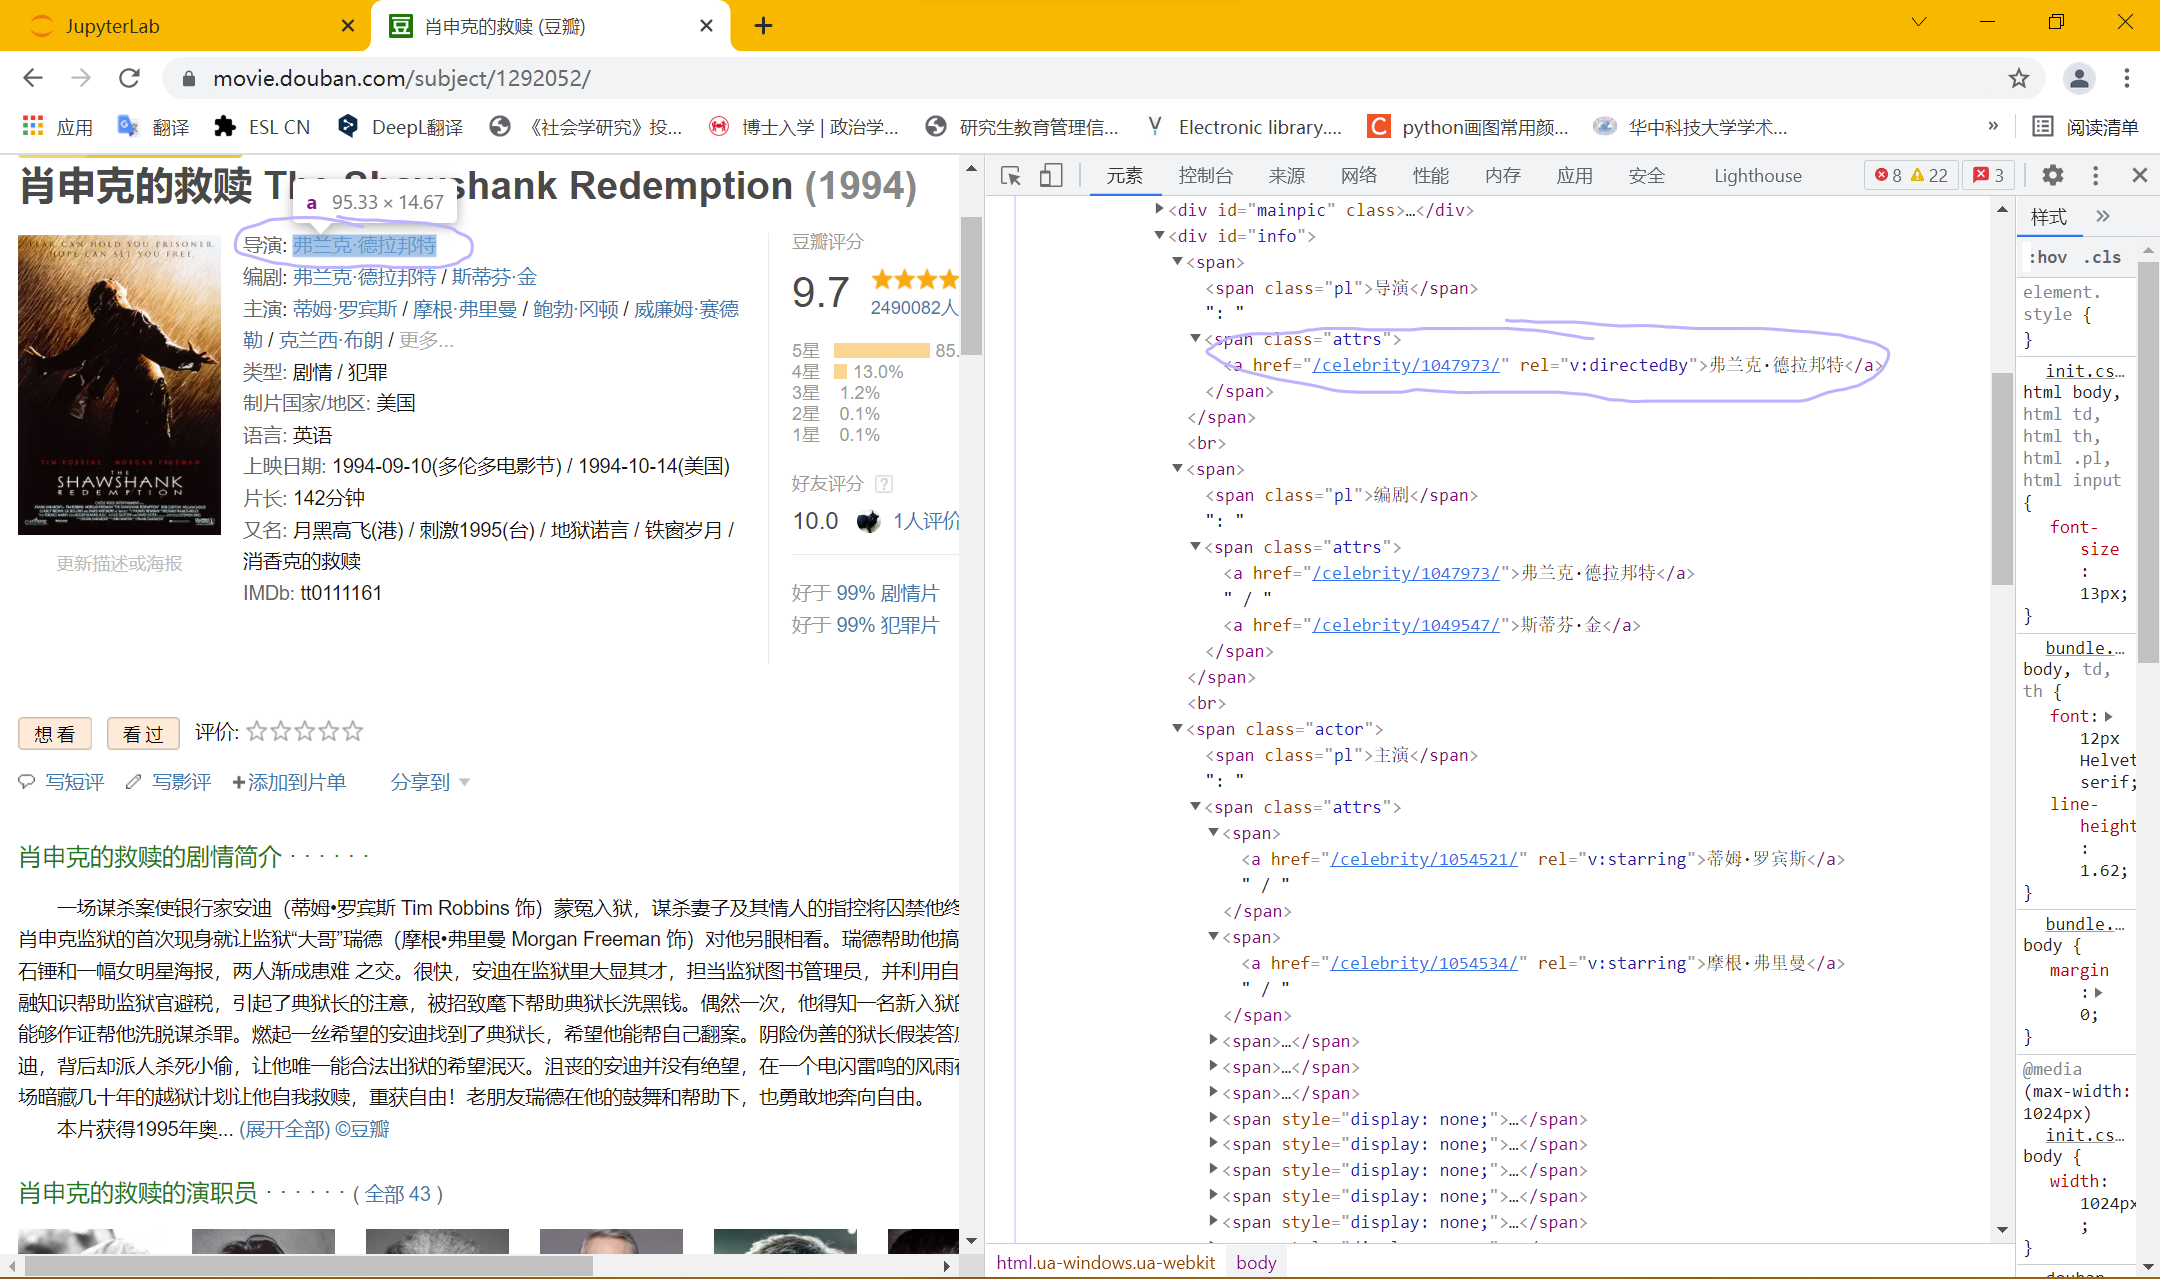

**图5 在电影页解析电影演员们**

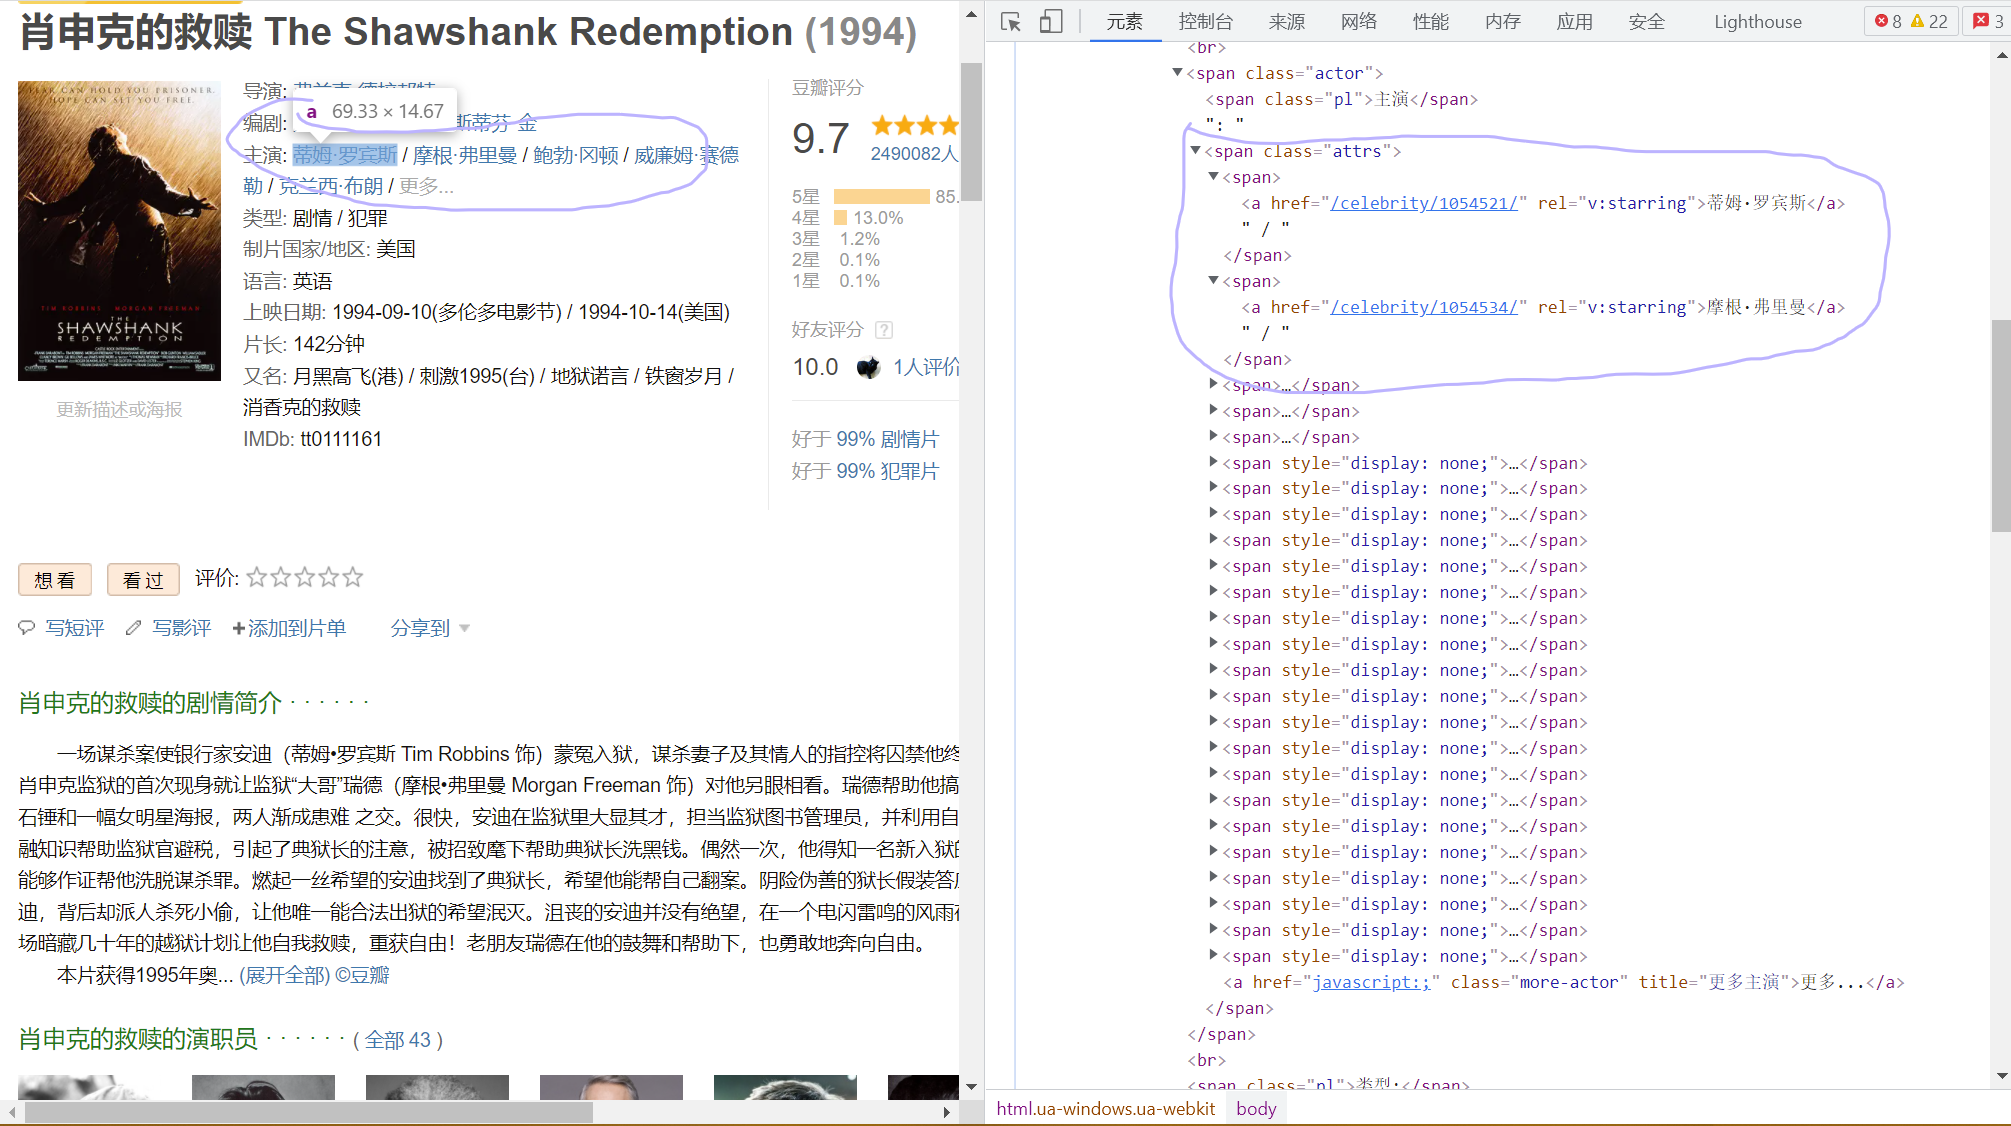

**图6 在电影页解析电影类型**

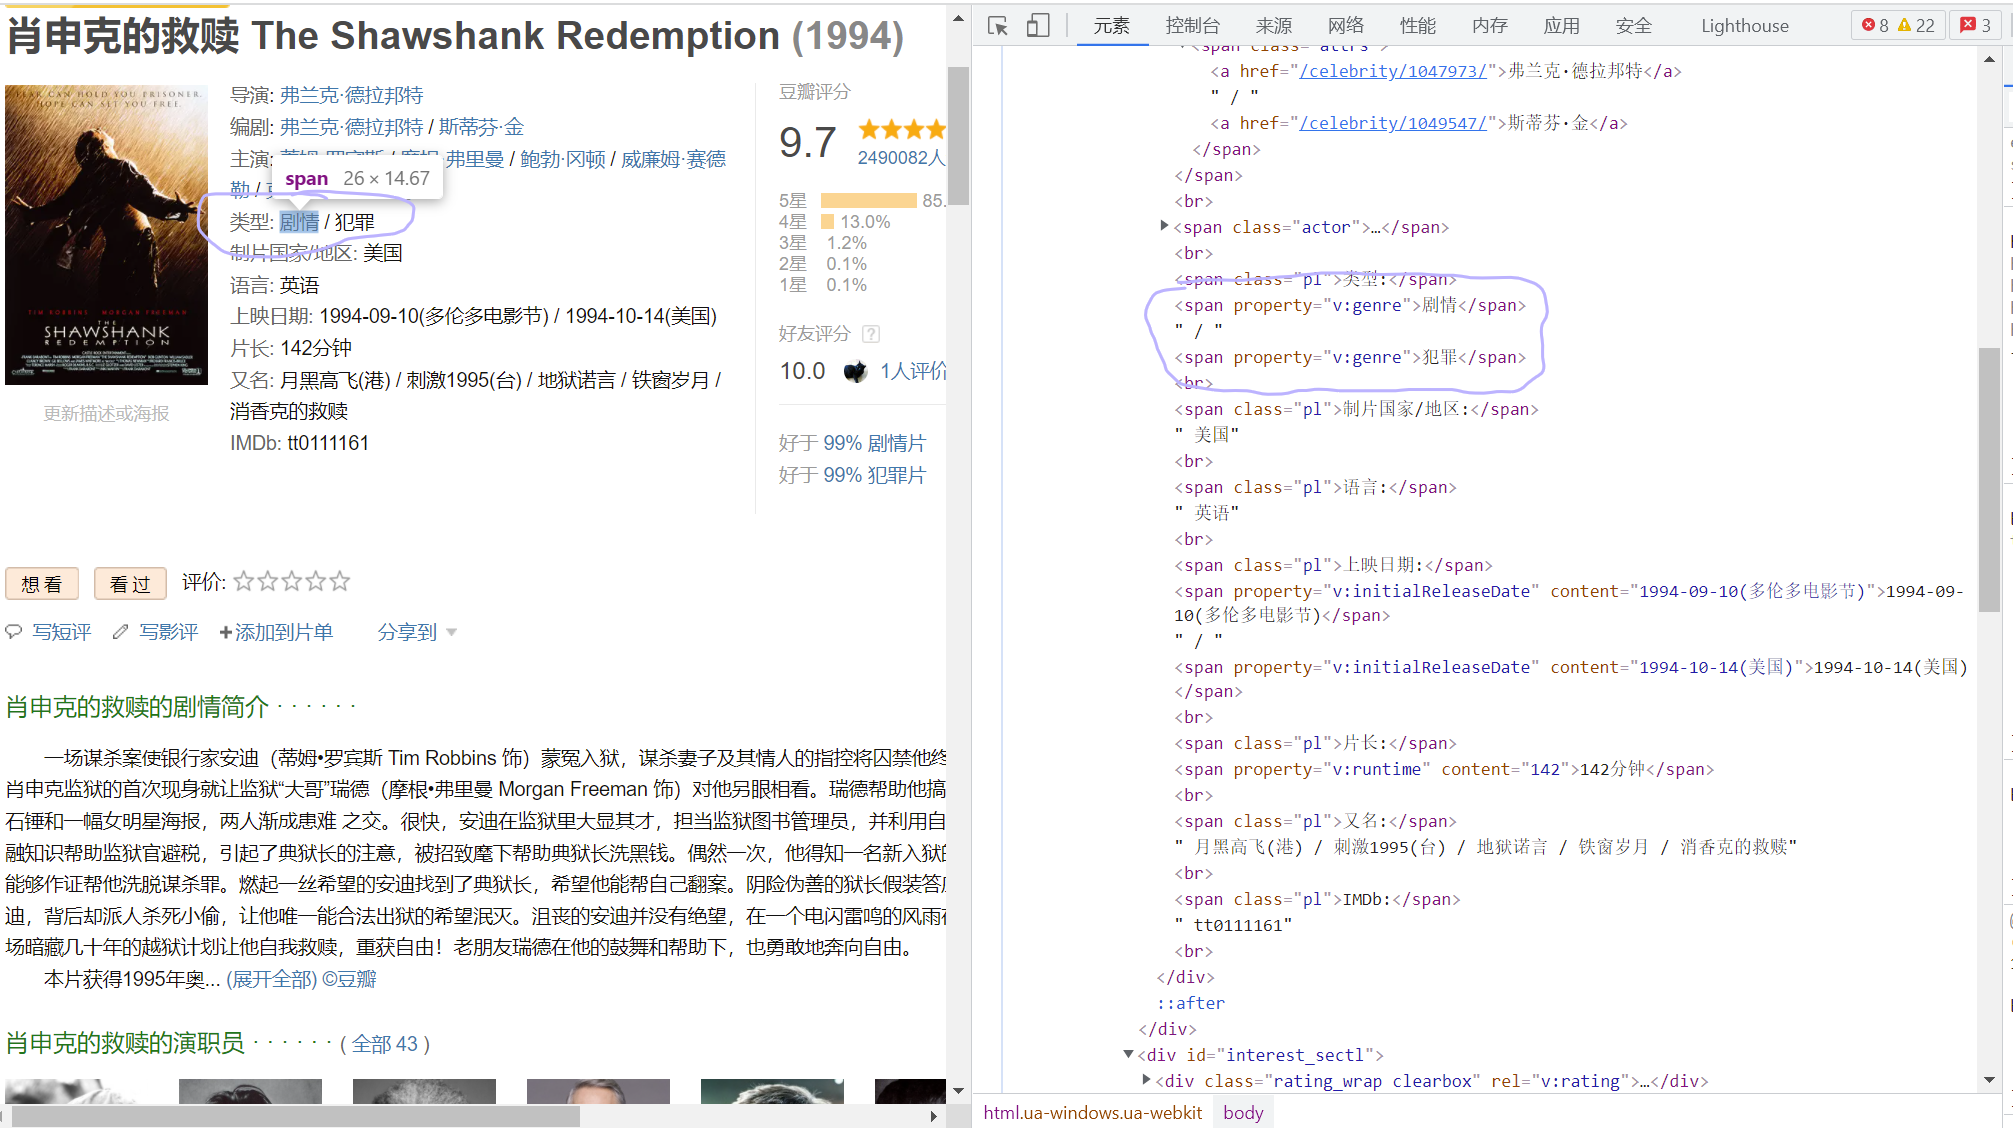

**图7 在电影页解析电影放映时间**

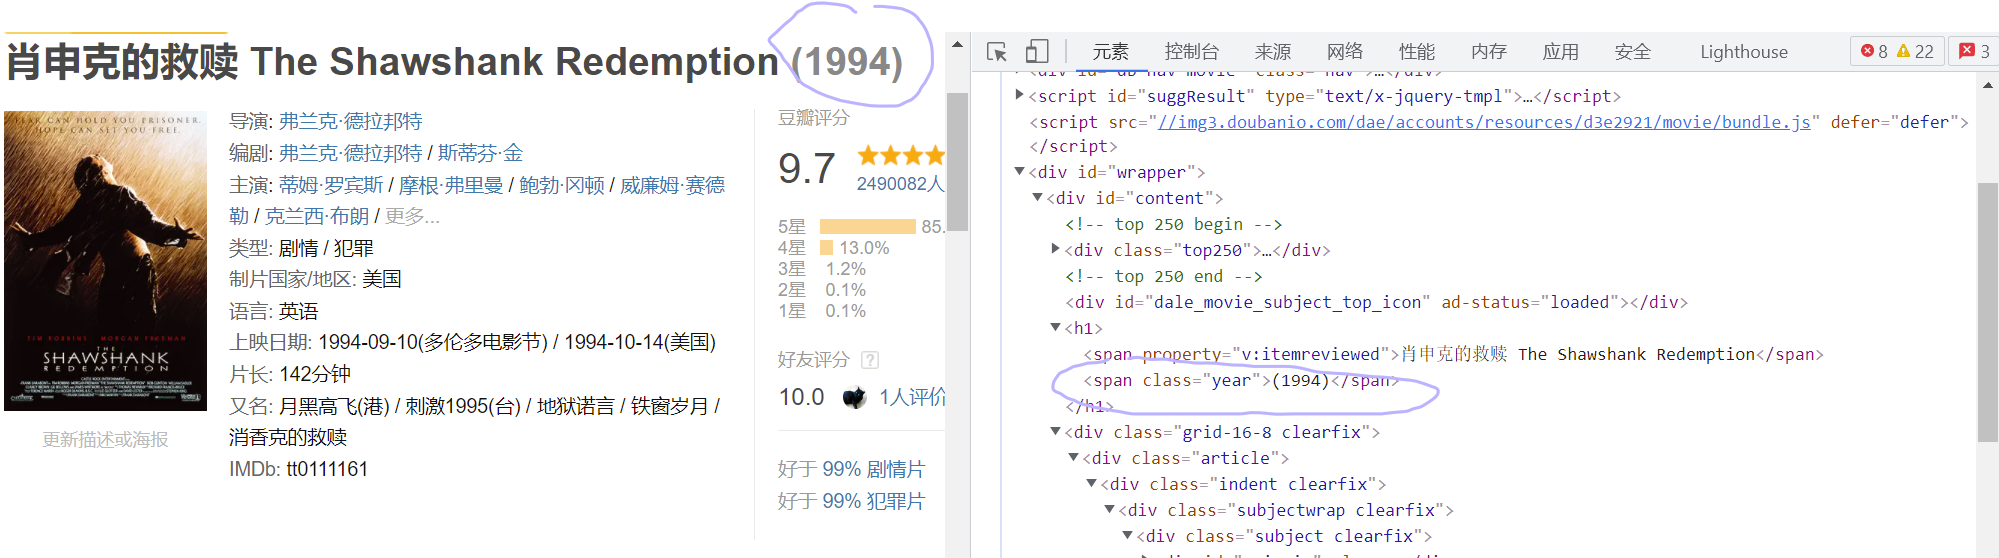

**图8 在电影页解析电影时长**

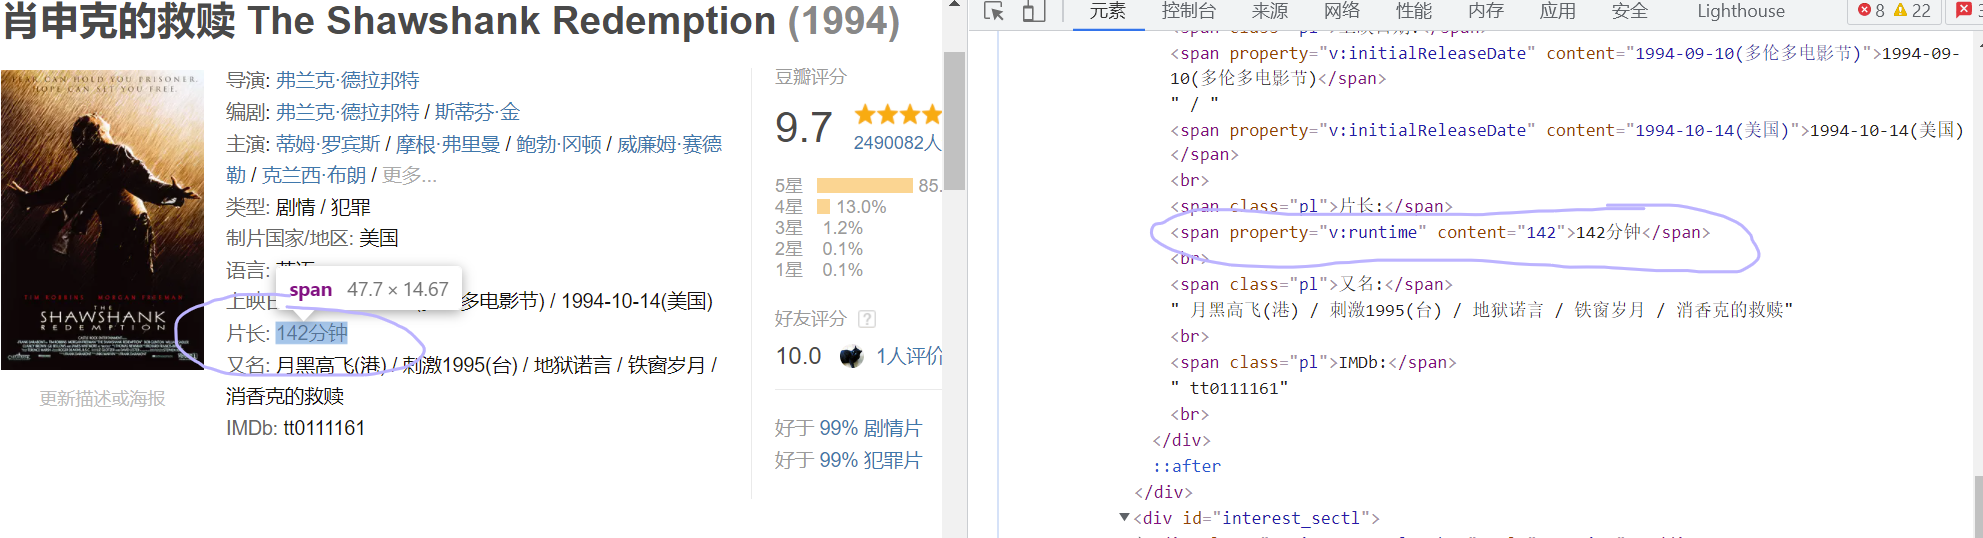

**图9 在电影页解析电影评分**

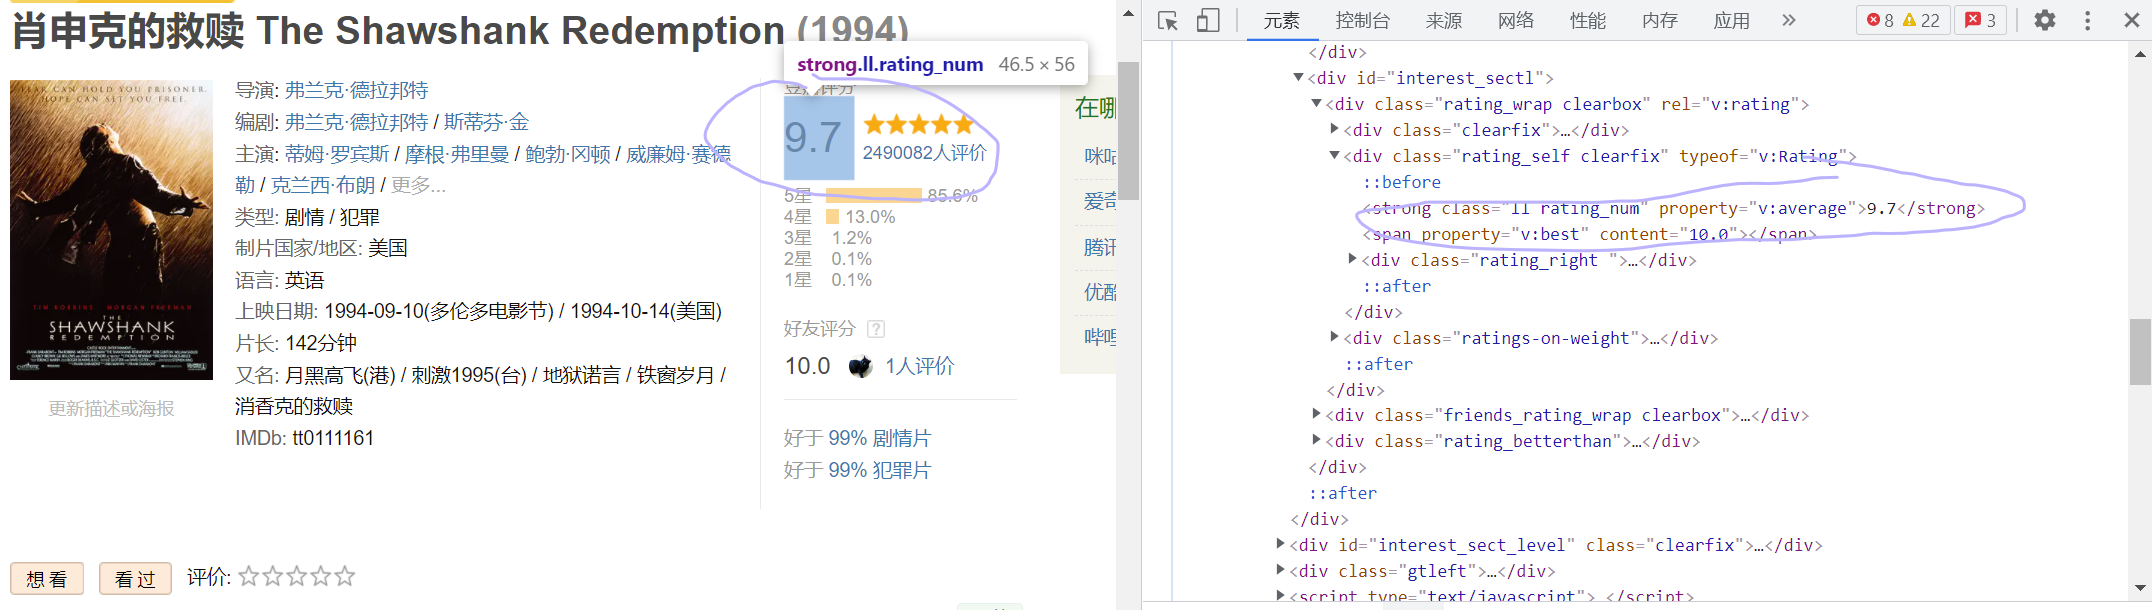

**图10 在电影页解析电影简介**

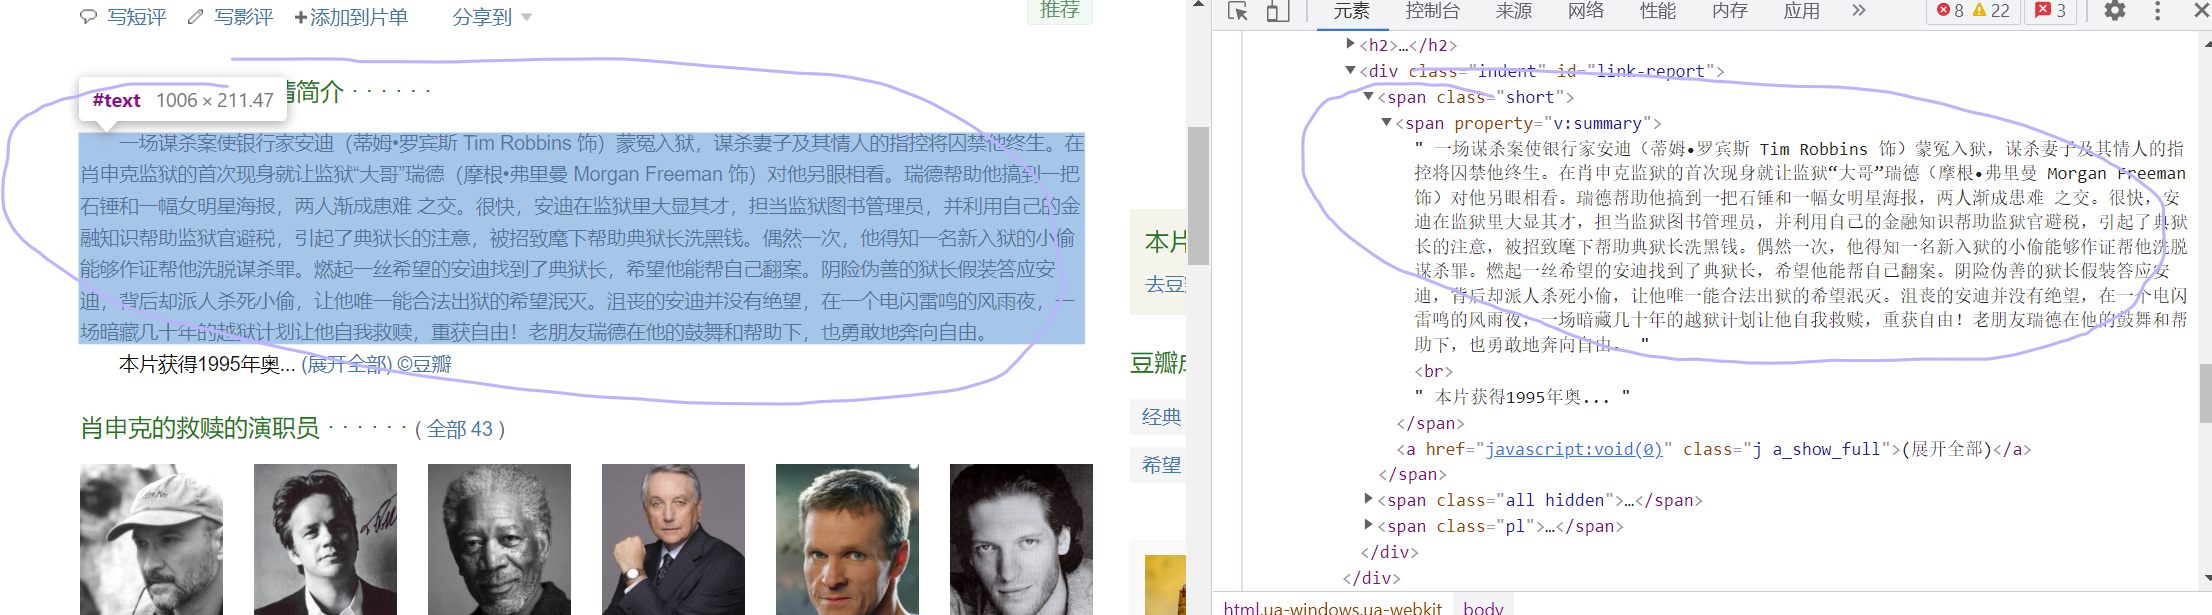

**4.启动我们的“装置”!**

我们第三段的代码已经对整个爬虫进行了完整的设计，接下来，只需要通过将这个装置实际运行起来，爬虫就开始自动运行啦！刚刚设计的“装置”仍然处在“图纸”层面，我们可以使用这个“图纸”，通过赋值进行实例化，“装置”就正式开始运行

In [11]:
my_spider = DoubanSpider()

正在处理第1页
https://movie.douban.com/top250?start=0
https://movie.douban.com/subject/1292052/
https://movie.douban.com/subject/1291546/
https://movie.douban.com/subject/1292720/
https://movie.douban.com/subject/1295644/
https://movie.douban.com/subject/1292722/
https://movie.douban.com/subject/1292063/
https://movie.douban.com/subject/1291561/
https://movie.douban.com/subject/1295124/
https://movie.douban.com/subject/3541415/
https://movie.douban.com/subject/3011091/
https://movie.douban.com/subject/1889243/
https://movie.douban.com/subject/1292064/
https://movie.douban.com/subject/1292001/
https://movie.douban.com/subject/3793023/
https://movie.douban.com/subject/2131459/
https://movie.douban.com/subject/1291549/
https://movie.douban.com/subject/1307914/
https://movie.douban.com/subject/25662329/
https://movie.douban.com/subject/1292213/
https://movie.douban.com/subject/5912992/
https://movie.douban.com/subject/1291841/
https://movie.douban.com/subject/1849031/
https://movie.douban.com/su